#  演示LSTM 的长期和短期记忆能力



以下是两组数据， 每组是一个长度为T=10的二维数组， y = sum( s * m)

让网络发现规律， 将T的长度放到200的时间序列上， LSTM 可以记住很久之前的m=1的信息， 普通的RNN 就不可以。 

```
 s=0.7581	m=1
 s=0.7010	m=0
 s=0.1807	m=0
 s=0.8387	m=0
 s=0.6760	m=0
 s=0.3419	m=0
 s=0.0420	m=0
 s=0.8913	m=0
 s=0.3688	m=1
 s=0.8188	m=0

0 -------------------   y = 1.1269

 s=0.9082	m=1
 s=0.9442	m=0
 s=0.3360	m=0
 s=0.1787	m=1
 s=0.4837	m=0
 s=0.2405	m=0
 s=0.3342	m=0
 s=0.0777	m=0
 s=0.7213	m=0
 s=0.5738	m=0
1 -------------------   y = 1.0869

```



In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
print(tf.__version__)


1.14.0


## 制作玩具数据集

In [2]:
def mask(T=200):
    mask = np.zeros(T)
    indices = np.random.permutation(np.arange(T))[:2]
    
    mask[indices] = 1
    return mask

def toy_problem(N=10, T=200):
    signals = np.random.uniform(low=0.0, high = 1.0, size=(N,T))
    masks = np.zeros((N, T))
    for i in range(N):
        masks[i] = mask(T)
        
    data = np.zeros((N, T, 2))
    data[:, :, 0] = signals[:]
    data[:, :, 1] = masks[:]
    target = (signals * masks).sum(axis =1).reshape(N, 1)
    
    return (data, target)

In [3]:
N = 2
T = 8

maxlen = T
X, Y = toy_problem(N=N, T=T)

def print_data(X, Y):
    
    for i in range(len(X)):
        

        for item in X[i]:
            print(' s={:.4f}\tm={}'.format( item[0], int(item[1])))
        print("{} -------------------   y = {:.4f}\n".format(i, Y[i][0]))
        
print_data(X, Y)

 s=0.3727	m=0
 s=0.6406	m=0
 s=0.1453	m=1
 s=0.7151	m=0
 s=0.3886	m=1
 s=0.1454	m=0
 s=0.8361	m=0
 s=0.1201	m=0
0 -------------------   y = 0.5339

 s=0.8487	m=0
 s=0.4866	m=1
 s=0.3394	m=0
 s=0.4808	m=0
 s=0.1159	m=0
 s=0.7273	m=0
 s=0.5736	m=1
 s=0.5462	m=0
1 -------------------   y = 1.0602



In [4]:
N = 10000
T = 200

maxlen = T
X, Y = toy_problem(N=N, T=T)

In [5]:
N_train = int(N * 0.9)
N_validation= N - N_train

X_train, X_validation , Y_train, Y_validation = train_test_split(X, Y , test_size = N_validation)

In [6]:
print('X_train shape  {}'.format(X_train.shape))
print('Y_train shape  {}'.format(Y_train.shape))
print('X_train length: {}'.format(len(X_train)))

X_train shape  (9000, 200, 2)
Y_train shape  (9000, 1)
X_train length: 9000


## 定义网络 误差函数和训练方法

In [7]:
# 定义网络
def inference(x, cell, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
#     cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
#     cell = tf.contrib.rnn.BasicLSTMCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    
    state = initial_state
    outputs = []
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t>0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
            
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c
    
    return y

# 均方差误差
def loss(y, t):
    return tf.reduce_mean(tf.square(y-t))

# 训练方法 AdamOptimizer
def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    
    train_step = optimizer.minimize(loss)
    return train_step
        

In [8]:
# 连续若干次没有提升精确率， 就停止训练
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step =0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose
        
    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping {}'.format(self._step))
                return True
            else:
                self._step = 0
                self._loss = loss
            
            return false

## 设置参数

In [9]:
tf.reset_default_graph()
lstm_history = {
    'val_loss': []
}

n_in = len(X[0][0])
n_hidden = 20
n_out = len(Y[0])

early_stopping = EarlyStopping(patience = 10, verbose=1)

x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(dtype=tf.int32, shape=[])

cell = tf.contrib.rnn.BasicLSTMCell(n_hidden)

y = inference(x, cell, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out)
loss_ = loss(y, t)

train_step = training(loss_)
epochs = 200
batch_size = 128

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## 进行训练

In [10]:
%%time
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = N_train // batch_size

for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            sess.run(train_step, feed_dict={
                x: X_[start:end], 
                t: Y_[start:end], 
                n_batch: batch_size})
            
    val_loss = loss_.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation, 
        n_batch: N_validation
    })
    

    lstm_history['val_loss'].append(val_loss)
#     history['val_acc'].append(val_acc)
    if epoch % 10 == 0 :
        print('epoch: {},  val loss: {}'.format(epoch, val_loss))
    if early_stopping.validate(val_loss):
        break

        


epoch: 0,  val loss: 0.17147813737392426
epoch: 10,  val loss: 0.16716787219047546
epoch: 20,  val loss: 0.16723208129405975
epoch: 30,  val loss: 0.16737017035484314
epoch: 40,  val loss: 0.1671610176563263
epoch: 50,  val loss: 0.16717232763767242
epoch: 60,  val loss: 0.16697929799556732
epoch: 70,  val loss: 0.018566789105534554
epoch: 80,  val loss: 0.016576269641518593
epoch: 90,  val loss: 0.005324806086719036
epoch: 100,  val loss: 0.004694924224168062
epoch: 110,  val loss: 0.0031049950048327446
epoch: 120,  val loss: 0.002672194968909025
epoch: 130,  val loss: 0.002435452537611127
epoch: 140,  val loss: 0.001532074878923595
epoch: 150,  val loss: 0.0011548337060958147
epoch: 160,  val loss: 0.0009312199545092881
epoch: 170,  val loss: 0.0007638774695806205
epoch: 180,  val loss: 0.000835736223962158
epoch: 190,  val loss: 0.0030731833539903164
epoch: 200,  val loss: 0.0004720991419162601
epoch: 210,  val loss: 0.000463073723949492
epoch: 220,  val loss: 0.0004922615480609238


In [ ]:
lstm_val_loss = lstm_history['val_loss']
plt.plot(range(epochs), lstm_val_loss,label='acc' , color='red' )


## 用RNN 训练

In [11]:
tf.reset_default_graph()
rnn_history = {
    'val_loss': []
}

 
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(dtype=tf.int32, shape=[])

cell = tf.contrib.rnn.BasicRNNCell(n_hidden)

y = inference(x, cell, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out)
loss_ = loss(y, t)

train_step = training(loss_)


init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            sess.run(train_step, feed_dict={
                x: X_[start:end], 
                t: Y_[start:end], 
                n_batch: batch_size})
            
    val_loss = loss_.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation, 
        n_batch: N_validation
    })
    

    rnn_history['val_loss'].append(val_loss)
#     history['val_acc'].append(val_acc)
    if epoch % 10 == 0 :
        print('epoch: {},  val loss: {}'.format(epoch, val_loss))
    if early_stopping.validate(val_loss):
        break


Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
epoch: 0,  val loss: 0.16859638690948486
epoch: 10,  val loss: 0.1673058271408081
epoch: 20,  val loss: 0.16717372834682465
epoch: 30,  val loss: 0.16723325848579407
epoch: 40,  val loss: 0.16718731820583344
epoch: 50,  val loss: 0.16738282144069672
epoch: 60,  val loss: 0.16742773354053497
epoch: 70,  val loss: 0.16718259453773499
epoch: 80,  val loss: 0.1706978678703308
epoch: 90,  val loss: 0.16715310513973236
epoch: 100,  val loss: 0.16730903089046478
epoch: 110,  val loss: 0.16695579886436462
epoch: 120,  val loss: 0.16695739328861237
epoch: 130,  val loss: 0.16482195258140564
epoch: 140,  val loss: 0.1658288836479187
epoch: 150,  val loss: 0.16606830060482025
epoch: 160,  val loss: 0.16606982052326202
epoch: 170,  val loss: 0.16372230648994446
epoch: 180,  val loss: 0.16672538220882416
epoch: 190,  val loss: 0.1661900132894516
epoch: 200,  val loss

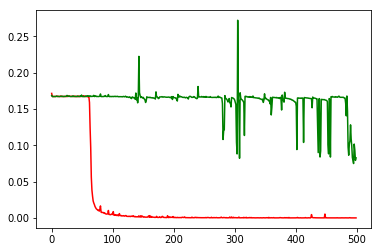

In [12]:
lstm_val_loss = lstm_history['val_loss']
rnn_val_loss = rnn_history['val_loss']
plt.plot(range(epochs), lstm_val_loss,label='acc' , color='red' )
plt.plot(range(epochs), rnn_val_loss,label='acc' , color='green' )

绿色的曲线是普通RNN ， 一直不收敛， 无法发现长期的规律。 

红色的曲线是LSTM， 在训练的过程中会学习到长期的规律， 预测准确率会迅速提升